# Machine learning models to classify methylation from MSC $p$-values

> Christopher Kimmel | 9/4/2020
>
> kimmel.95@osu.edu

This notebook writes and evaluates several machine-learning classifiers to identify whether HIV strands are m6A modified at zero-based nucleotide position 8078.
Reads with known modification status were sequenced in an ONT Min-ION device, then $p$-values were extracted using Tombo's `model_sample_compare` (MSC) feature with `fisher_context=0`.
The resulting $p$-values are stored in the CSV files in this directory.

What I just wrote is probably gibberish to people outside our lab. If you're reading this and you have any questions at all, please email me at kimmel.95@osu.edu. I like emails from non-robots.

## Table of Contents
* [Load Training Data](#load_training_data)
* [Explore Training Data](#explore_training_data)
* [Configure Training and Testing Framework](#configure_training_and_testing_framework)
* [Design Models](#design_models)
* [Test Models](#test_models)

In [148]:
import numpy as np
import pandas as pd
import sklearn.decomposition

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load Training Data<a name="load_training_data"></a>

In [92]:
paths = {'pos': '082720_8079m6A_positive_fishers0.csv',
         'neg': '082720_8079m6A_negative_fishers0.csv'}
tables = {}
for key, path in paths.items():
    tables[key] = pd.read_csv(
        paths[key],
        header=0,
        index_col=0,
        usecols=['read_id'] + [str(x) for x in range(8071, 8080+1)], # only extract the columns we need
    )
    tables[key].columns = map(
        (lambda x: int(x) if x.isdecimal() else x), # Sorry
        tables[key].columns,
    )

In [93]:
print('pos')
display(tables['pos'].head())
print('neg')
display(tables['neg'].head())

pos


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
001049b1-b30e-4442-b12e-af4ffb502dd0,0.908730,0.819033,0.727309,0.832426,0.056014,0.016025,0.434485,0.290166,0.082475,0.543456
00bb1e66-ae04-48f1-a406-811c47a1c895,0.611121,0.000193,0.080047,0.014755,0.106225,0.916429,0.165774,0.222060,0.981883,0.650183
0126a6dc-156e-4621-af1e-f032869dc80b,0.845334,0.001125,0.708078,0.122484,0.219383,0.029931,0.159753,0.642982,0.349679,0.834660
022c5d7e-be67-4dd5-8766-b7272e09ac89,0.735947,0.822537,0.592670,0.301647,0.198147,0.070637,0.553212,0.678010,0.209285,0.958817
0239fb65-639f-4206-99af-d1955c242ceb,0.699882,0.005003,0.994960,0.615499,0.003001,0.190562,0.609684,0.325872,0.465964,0.726206


neg


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
00a0a871-6886-45c8-a6b9-65d0ba800069,0.720210,0.789149,0.420912,0.087897,0.272514,5.317310e-01,0.661067,0.609795,0.045854,0.657107
00ecb296-3580-4d75-9d1f-a6b6fedc3e01,0.549433,0.776922,0.286839,0.978955,0.351899,9.126486e-01,0.380977,0.566955,0.298615,0.719023
012e93bb-1005-4f3b-93fd-1ea1e47ffe47,0.743258,0.264297,0.768545,0.358252,0.476503,1.423748e-01,0.160891,0.362595,0.144221,0.000053
01b83cf0-0d78-453a-8e6a-e6b2187fd32f,0.580595,0.665775,0.010144,0.758974,0.300949,7.496507e-01,0.181335,0.632513,0.076767,0.937543
01c5c647-deb2-4144-8d64-baafb7d258ad,0.490944,0.895945,0.749461,0.415461,0.127709,3.200000e-17,0.736028,0.925196,0.740035,0.520994


In [97]:
tables['pos']['mod'] = 1
tables['neg']['mod'] = 0
table = pd.concat(tables.values())

In [98]:
display(table)

,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080,mod
read_id,,,,,,,,,,,
001049b1-b30e-4442-b12e-af4ffb502dd0,0.908730,0.819033,0.727309,0.832426,0.056014,0.016025,0.434485,0.290166,0.082475,0.543456,1
00bb1e66-ae04-48f1-a406-811c47a1c895,0.611121,0.000193,0.080047,0.014755,0.106225,0.916429,0.165774,0.222060,0.981883,0.650183,1
0126a6dc-156e-4621-af1e-f032869dc80b,0.845334,0.001125,0.708078,0.122484,0.219383,0.029931,0.159753,0.642982,0.349679,0.834660,1
022c5d7e-be67-4dd5-8766-b7272e09ac89,0.735947,0.822537,0.592670,0.301647,0.198147,0.070637,0.553212,0.678010,0.209285,0.958817,1
0239fb65-639f-4206-99af-d1955c242ceb,0.699882,0.005003,0.994960,0.615499,0.003001,0.190562,0.609684,0.325872,0.465964,0.726206,1
...,...,...,...,...,...,...,...,...,...,...,...
fe7485a6-2e66-47f1-815b-972bd583aca4,0.763787,0.192113,0.500462,0.595861,0.175142,0.635956,0.093604,0.598011,0.073168,0.528793,0
fecaaa10-576c-4889-b76d-8e3bb1a68792,0.225264,0.493378,0.734564,0.587567,0.668571,0.976204,0.027672,0.819617,0.264074,0.763034,0
feff2c2e-3e56-4d72-85a7-6c78a8bbeaa1,0.382975,0.632045,0.609480,0.789779,0.608523,0.357777,0.884019,0.640690,0.575116,0.345352,0


In [194]:
x = table.drop('mod', axis=1)
y = table['mod']
print('x')
display(x.sample(7))
print('y')
display(y.sample(7))

x


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
a94b2f1f-2f42-41af-8301-728183de3e6f,0.917872,0.363724,0.588607,0.236624,0.751765,0.091998,0.017233,0.549452,0.107506,0.758215
0d9a887e-9e78-4f8f-94b7-bf1aca2f1227,0.215948,0.782994,0.133497,0.822712,0.396158,0.383401,0.365756,0.954565,0.618464,0.341961
de9919f8-9345-4e1b-8cfb-1e609dd2b005,0.867068,0.856873,0.625280,0.674275,0.115428,0.086292,0.193805,0.314561,0.832858,0.896465
6ca5679a-00b1-4005-be1c-d2696cb70a6b,0.712079,0.619643,0.442800,0.961385,0.794186,0.075608,0.652780,0.460752,0.046328,0.581102
41fb4c8e-fd11-48f9-8b27-cb61fdf0461d,0.878488,0.009555,0.934912,0.559592,0.732468,0.005791,0.364188,0.761517,0.300873,0.764714
e7c3af5f-5525-494e-8b88-ff255f73b585,0.270404,0.089598,0.314639,0.126509,0.623978,0.555392,0.086107,0.741422,0.672169,0.882407
3131c14b-6f5e-43c3-b99c-dfcea3793877,0.517467,0.049975,0.516427,0.530095,0.755020,0.000018,0.731112,0.404526,0.719808,0.995108


y


read_id
f0de6f47-668f-4c70-b350-bbfac78da0f3    0
693d8b1f-2b8b-49a1-b4de-25dd669f2883    0
2d27a1c2-cf66-4d33-83d5-0da4d803acfa    0
7176b718-13ec-4adc-a6d6-57c7d917c64a    1
a40e709b-53a2-413e-9028-a56c3c5c531a    1
d609cc5b-7e48-4261-8749-05e7a8b3012f    1
5c3d3689-e932-4a77-986b-c85967e23d40    0
Name: mod, dtype: int64

## Explore Training Data<a name='explore_training_data'>

Reduce to two dimensions with PCA and plot with two colors.

In [142]:
to_plot = table[list(range(8074, 8080+1)) + ['mod']].sample(frac=0.1)

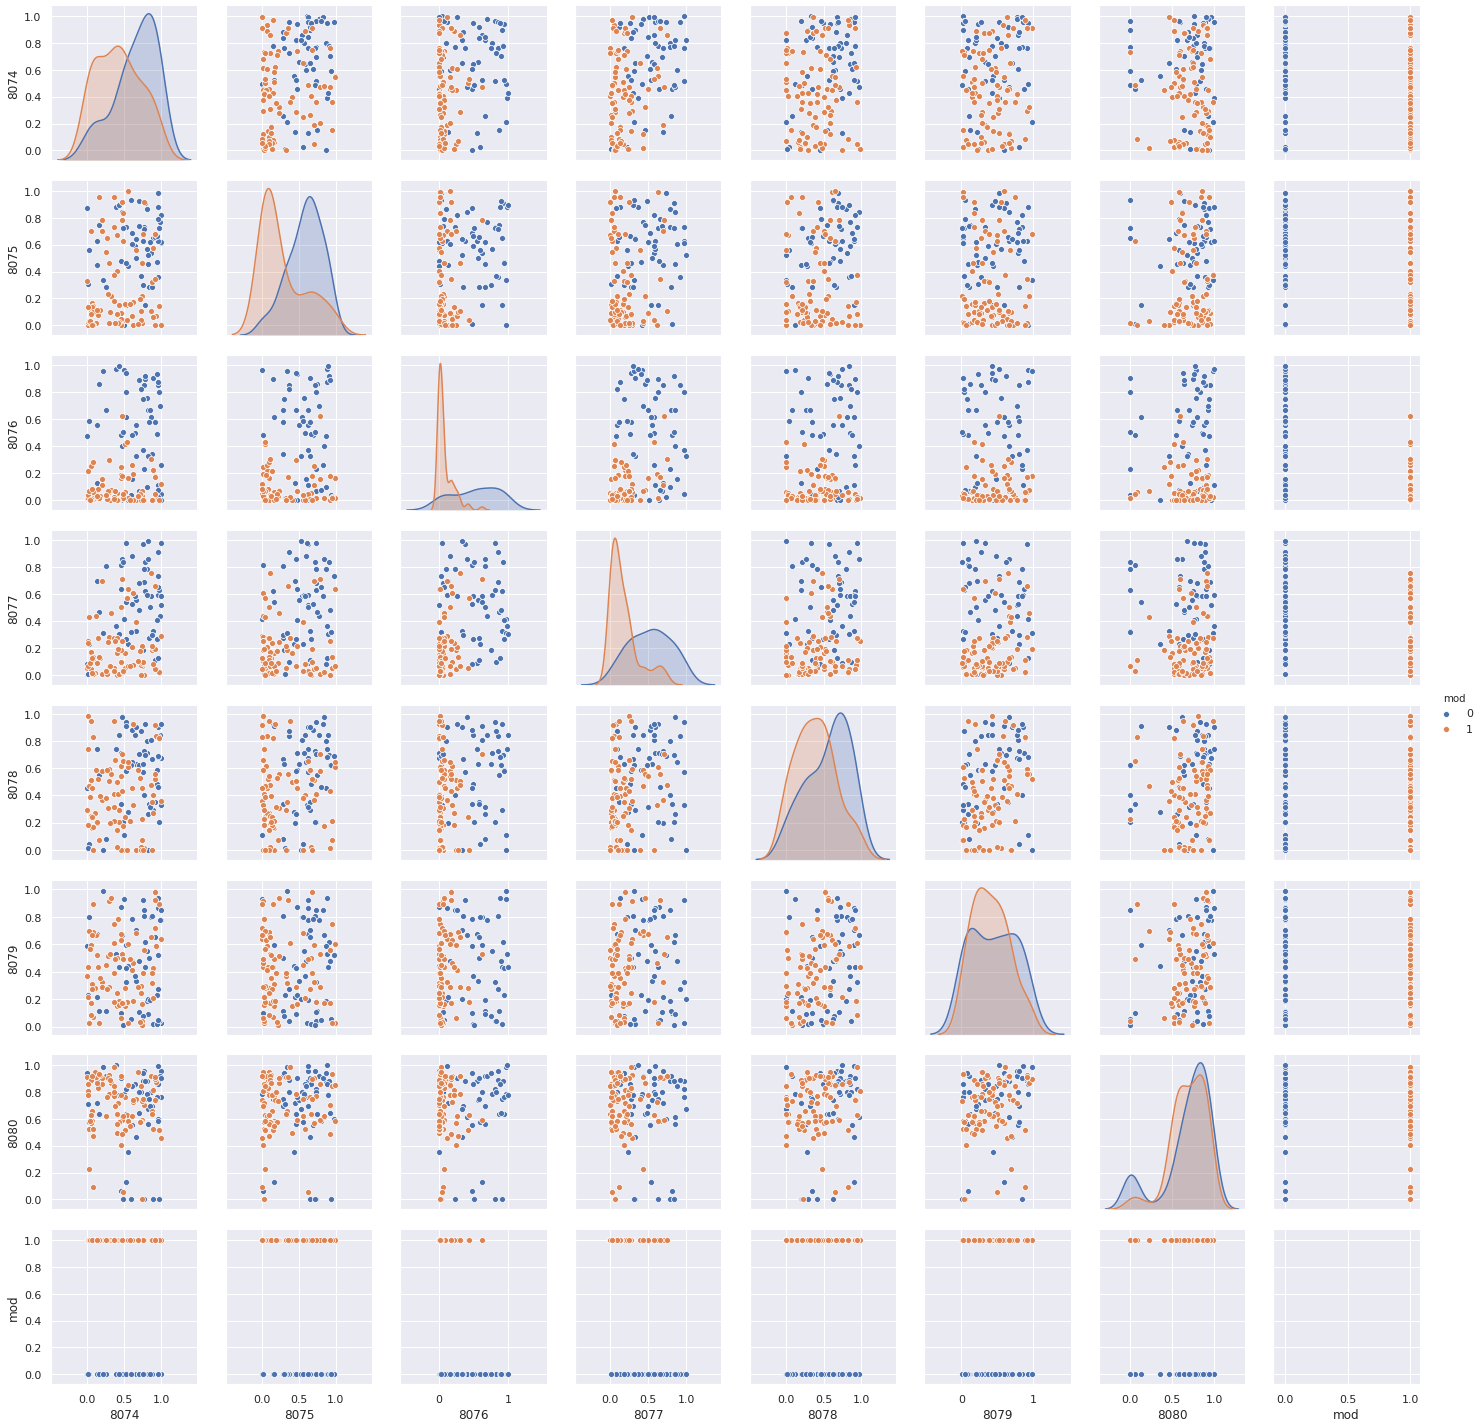

In [144]:
sns_plot = sns.pairplot(to_plot, hue='mod')
sns_plot.savefig('pairplot.png')

Log-scaling the data makes the explained-variance ratio closer to one with fewer components.
I guess that makes sense.

In [236]:
pca_model = sklearn.decomposition.PCA()
pca_fitted = pca_model.fit(x.dropna())

In [237]:
pca_fitted.explained_variance_ratio_.cumsum()

array([0.23543922, 0.3480352 , 0.4554045 , 0.55365289, 0.64518722,
       0.72838537, 0.80675856, 0.8775473 , 0.9452154 , 1.        ])

In [238]:
mean = x.dropna().values.mean(axis=0) # + pca_fitted.components_[0]

print('pos\tmean\tcomp1\tcomp2')
for pos, mean_entry, comp1, comp2 in zip(x.columns, mean, *pca_fitted.components_[0:2]):
    print('{}\t{: .3f}\t{: .3f}\t{: .3f}'.format(pos, mean_entry, comp1, comp2))

pos	mean	comp1	comp2
8071	 0.531	-0.078	-0.426
8072	 0.531	-0.072	-0.481
8073	 0.472	-0.090	-0.402
8074	 0.501	-0.376	-0.364
8075	 0.405	-0.471	-0.244
8076	 0.300	-0.493	 0.299
8077	 0.350	-0.457	 0.245
8078	 0.484	-0.349	 0.277
8079	 0.458	-0.186	 0.039
8080	 0.685	-0.095	-0.075


Do some logistic regression. (TLS? OLS? GLS?)
Maybe even test for normality.
Plot the first two dimension